In [49]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

####################################################################################
city_len = 1860
ex_flg = False
####################################################################################

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
pop_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
msk_dir = f'{h08dir}/global_city/dat/vld_cty_'
cnt_dir = f'{h08dir}/global_city/dat/cty_cnt_/gpw4'
prf_dir = f'{h08dir}/global_city/dat/cty_prf_'

rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
pop = np.fromfile(pop_path, dtype='float32').reshape(2160, 4320)
rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)

lonlat_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/WUP2018_300k_2010.txt'
with open(lonlat_path, "r") as input_file:
    lines = input_file.readlines()

# identifying same rivnum cities into list?
city_basins = {}
for i in range(city_len):
    city_num = i+1
    ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'

    if not os.path.exists(prf_path):
        print(f'{city_num} is invalid prf')

    else:
        ctymsk = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        rivnum_mask = np.ma.masked_where(prf == 0, rivnum_gl5)
        rivnum_lst = np.unique(rivnum_mask)[:-1]
        city_basins[city_num] = rivnum_lst.filled(1e20)
        
        #largest_rivnum = np.min(rivnum_mask)
        #mask = (rivnum == largest_rivnum)
        #print('rivnum', city_num, largetst_rivnum)
        print(f'{city_num} done')

print(city_basins)

"""
basin_to_cities = {}
for city, basins in city_basins.items():
    for rivnum in basins:
        if rivnum not in basin_to_cities:
            basin_to_cities[rivnum] = []
        basin_to_cities[rivnum].append(city)

# 集計結果を出力
for rivnum, cities in basin_to_cities.items():
    if len(cities) > 1:  # 複数の都市に共有されている流域番号のみ表示
        print(f"rivnum {rivnum}: {cities}")

import json
city_basins_list = {city: basins.tolist() for city, basins in city_basins.items()}
cityrivnum = f'{h08dir}/global_city/dat/riv_num_/city_basins.json'
with open(cityrivnum, 'w') as json_file:
    json.dump(city_basins_list, json_file)
print(f'{cityrivnum} saved')
"""

1 done
2 done


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f26d03b32b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [225]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
################################################################################
# load files
################################################################################

# rivnxl in xy coord
riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)

# basin at each city
cityrivnum = f'{h08dir}/global_city/dat/riv_num_/city_basins.json'
with open(cityrivnum, 'r') as json_file:
    city_basins = json.load(json_file)
print(len(city_basins.keys()))

# cities at same basin
basin_to_cities = {}
for city, basins in city_basins.items():
    for rivnum in basins:
        if rivnum not in basin_to_cities:
            basin_to_cities[rivnum] = []
        basin_to_cities[rivnum].append(city)
        
for rivnum, cities in basin_to_cities.items():
    if len(cities) > 1:  # 複数の都市に共有されている流域番号のみ表示
        print(f"rivnum {rivnum}: {cities}")
        
new_basin_to_cities = {rivnum: cities for rivnum, cities in basin_to_cities.items() if len(cities) > 1}
basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities.json'
with open(basin_cities_path, 'w') as json_file:
    json.dump(new_basin_to_cities, json_file)
    print(f'{basin_cities_path} saved')

1553
rivnum 848.0: ['1', '936', '1283', '1400']
rivnum 14.0: ['2', '11', '126', '130', '133', '188', '197', '217', '243', '319', '321', '363', '406', '455', '463', '473', '513', '526', '588', '667', '669', '673', '677', '797', '883', '903', '941', '983', '1012', '1018', '1067', '1089', '1181', '1216', '1253', '1288', '1298', '1337', '1365', '1371', '1381', '1422', '1575', '1578', '1620', '1652', '1656', '1668', '1697', '1712', '1718', '1824']
rivnum 480.0: ['3', '52', '85', '144', '160', '612', '618', '967', '1200', '1299', '1376', '1687']
rivnum 5438.0: ['3', '85']
rivnum 164.0: ['4', '537', '933']
rivnum 5.0: ['5', '94', '119', '140', '155', '196', '257', '343', '550', '597', '629', '689', '789', '803', '836', '837', '866', '1235', '1327', '1329', '1361', '1411', '1453', '1500', '1530', '1573', '1648', '1720']
rivnum 4.0: ['9', '71', '200', '579', '691', '746', '1551', '1579', '1667', '1675', '1676', '1747']
rivnum 172.0: ['10', '183', '334', '386', '910', '1265', '1439']
rivnum 1124

In [288]:
def updown(new_basin_to_cities, key_index=0):
    # get uid and city list
    keys_list = list(new_basin_to_cities.keys())
    uid = keys_list[key_index]
    print(f'uid: {uid}')
    rivnum_list = new_basin_to_cities[uid]
    rivnum_list = [int(i) for i in rivnum_list]
    
    # remove overlap
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    rivnum_list_removed = [num for num in rivnum_list if num not in numbers]
    rivnum_list_removed = [int(i) for i in rivnum_list_removed]
    print('cities in uid')
    print(rivnum_list_removed)
    
    # coord of purficication
    coords_a = []
    for city_num in rivnum_list_removed:
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        uid = int(float(uid))
        prf_coord = np.where((prf == 1) & (rivnum_gl5 == uid))
        coords_a.append(prf_coord)
    print(coords_a)
    #print(coords_a)
    
    # down??
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    for cid in range(len(coords_a)):
        visited_coords = set()
        riv_path_array[coords_a[cid][0][0], coords_a[cid][1][0]] = cid
        
        coords_b = coords_a.copy()
        coords_b.pop(cid) 
        cind_list = rivnum_list_removed.copy()
        cind_list.pop(cid)
        
        if len(coords_a) > 0:
            target_coord = (coords_a[cid][0][0], coords_a[cid][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = cid
                target_coord = next_coord
        
        for cind, coord in enumerate(coords_b):
            standard_coord = (coord[0][0], coord[1][0])
            if standard_coord in visited_coords:
                #print(f"upstream: city{rivnum_list_removed[cid]}, downstream: city{cind_list[cind]}")
                edges.append((rivnum_list_removed[cid], cind_list[cind]))
            #else:
                #print("no city in downstream")

    # edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
    return edges, riv_path_array, coords_a, rivnum_list_removed

In [283]:
def find_upstream_cities(edges, city_number):
    cities_with_upstream = []
    cities_without_upstream = []
    upstream_cities = [edge[0] for edge in edges if edge[1] == city_number]
    uup = np.unique(upstream_cities)
    
    for i in uup:
        if any(edge[1] == i for edge in edges):
            # 上流にさらに都市が存在する場合
            cities_with_upstream.append(i)
        else:
            # 上流にこれ以上都市が存在しない場合
            cities_without_upstream.append(i)
    
    return cities_with_upstream, cities_without_upstream, uup
    
edges, riv_path_array, coords_a, rivnum_list_removed = updown(new_basin_to_cities, key_index=1)
unique_cities_basin = np.unique(edges)
# unique_cties_basin: uniqueなすべての都市
# uup: 各都市の上流にあるuniqueな都市

result_dict = {}
for city_number in unique_cities_basin:
    cities_with_upstream, cities_without_upstream, uup = find_upstream_cities(edges, city_number)
    if cities_with_upstream:
        result_dict[city_number] = [1, True, uup]
    elif not cities_with_upstream and cities_without_upstream:
        result_dict[city_number] = [1, False, uup]
    else:
        result_dict[city_number] = [1, 'Done', uup]

# 同じ流域に含まれる各都市のwater availability, upstream citiesを保存している．cities_with_upstreamが存在する場合，flag=Trueとなる

uid: 14.0
cities in uid
[2, 11, 126, 130, 133, 188, 197, 217, 243, 319, 321, 363, 406, 455, 463, 473, 513, 526, 588, 667, 669, 673, 677, 797, 883, 903, 941, 983, 1012, 1018, 1067, 1089, 1181, 1216, 1253, 1288, 1298, 1337, 1365, 1371, 1422, 1578, 1620, 1652, 1656, 1697, 1712, 1718, 1824]


In [284]:
for key in result_dict:
    value = result_dict[key]
    print(key, value)

2 [1, True, array([1253, 1288, 1620])]
126 [1, 'Done', array([], dtype=float64)]
130 [1, False, array([ 321,  463,  526, 1371, 1656, 1824])]
133 [1, 'Done', array([], dtype=float64)]
188 [1, 'Done', array([], dtype=float64)]
197 [1, True, array([   2,  126,  130,  133,  188,  217,  243,  319,  321,  363,  406,
        455,  463,  513,  526,  667,  669,  677,  797,  883,  941,  983,
       1018, 1067, 1089, 1253, 1288, 1298, 1337, 1371, 1422, 1620, 1656,
       1697, 1712, 1718, 1824])]
217 [1, 'Done', array([], dtype=float64)]
243 [1, True, array([   2,  667,  677,  983, 1067, 1089, 1253, 1288, 1422, 1620])]
319 [1, 'Done', array([], dtype=float64)]
321 [1, 'Done', array([], dtype=float64)]
363 [1, True, array([   2,  126,  188,  217,  243,  406,  455,  513,  667,  677,  797,
        883,  941,  983, 1018, 1067, 1089, 1253, 1288, 1298, 1337, 1422,
       1620, 1718])]
406 [1, 'Done', array([], dtype=float64)]
455 [1, False, array([ 188,  941, 1718])]
463 [1, 'Done', array([], dtype=flo

In [285]:
def explore(result_dict):
    while True:
        all_done = True  # 全てのflagが'Done'であるかをチェックするためのフラグ
        
        for key in result_dict:
            value = result_dict[key]
            flag = value[1]
            uup = value[2]
            ava = value[0]
            ava_mod = ava
            
            if flag != 'Done':
                all_done = False  # まだ'Done'でないflagがある場合、all_doneをFalseに設定
        
            if flag is False:
                flg_lst = []
                for kkk in uup:
                    oth_flg = result_dict[kkk][1]
                    flg_lst.append(oth_flg)
                    
                for kkk in uup:
                    oth_ava = result_dict[kkk][0]
                    ava_mod = ava_mod - np.abs(oth_ava)
                result_dict[key][0] = ava_mod
                result_dict[key][1] = 'Done'
                
            elif flag is True:
                flg_lst = []
                for kkk in uup:
                    oth_flg = result_dict[kkk][1]
                    flg_lst.append(oth_flg)
                
                if all(item == 'Done' for item in flg_lst):
                    # 重複を削除する
                    all_upstream = []
                    for kkk in uup:
                        all_upstream.extend(result_dict[kkk][2])
                    mod_uup = [city for city in uup if city not in all_upstream]
                    for kkk in mod_uup:
                        oth_ava = result_dict[kkk][0]
                        ava_mod = ava_mod - np.abs(oth_ava)
                    result_dict[key][0] = ava_mod
                    result_dict[key][1] = 'Done'
    
            else:
                flg_lst = []
                for kkk in uup:
                    oth_flg = result_dict[kkk][1]
                    flg_lst.append(oth_flg)
            print(key, flag, ava, flg_lst, uup)
                    
        print('-------------------------------------------------------------------------------------------i-----------------------------------------------------------------------------')
        if all_done:
            print('all_done')
            break  # 全てのflagが'Done'であればループを終了
    return result_dict

2 True 1 ['Done', False, 'Done'] [1253 1288 1620]
126 Done 1 [] []
130 False 1 ['Done', 'Done', 'Done', 'Done', 'Done', 'Done'] [ 321  463  526 1371 1656 1824]
133 Done 1 [] []
188 Done 1 [] []
197 True 1 [True, 'Done', 'Done', 'Done', 'Done', 'Done', True, 'Done', 'Done', True, 'Done', False, 'Done', 'Done', 'Done', 'Done', 'Done', 'Done', True, 'Done', 'Done', 'Done', 'Done', False, 'Done', 'Done', False, 'Done', 'Done', 'Done', 'Done', 'Done', 'Done', 'Done', 'Done', 'Done', 'Done'] [   2  126  130  133  188  217  243  319  321  363  406  455  463  513
  526  667  669  677  797  883  941  983 1018 1067 1089 1253 1288 1298
 1337 1371 1422 1620 1656 1697 1712 1718 1824]
217 Done 1 [] []
243 True 1 [True, 'Done', 'Done', 'Done', False, 'Done', 'Done', False, 'Done', 'Done'] [   2  667  677  983 1067 1089 1253 1288 1422 1620]
319 Done 1 [] []
321 Done 1 [] []
363 True 1 [True, 'Done', 'Done', 'Done', True, 'Done', False, 'Done', 'Done', 'Done', True, 'Done', 'Done', 'Done', 'Done', Fals

In [286]:
mcy_pop_water_path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/cty_lst_/gpw4/mcy_pop_water_12region.txt'
column_names = ['index', 'flag', 'rate', 'wup', 'pop', 'ava', 'mpcy', 'potential', 'region', 'country', 'cityname', '12region']
df = pd.read_csv(mcy_pop_water_path, delimiter='|', header=None, names=column_names)
df.head(10)

,index,flag,rate,wup,pop,ava,mpcy,potential,region,country,cityname,12region
0,1,False,0.863325,36859.626,31821850.0,1.424091e+10,447.519821,93.0,eastern asia,Japan,Tokyo,East Asia
1,2,False,1.003201,21987.895,22058268.0,4.420798e+09,200.414547,39.0,southern asia,India,Delhi,South Asia
2,3,False,0.715760,20314.309,14540163.0,1.643563e+10,1130.360505,17.0,eastern asia,China,Shanghai,East Asia
3,4,False,1.002057,20136.681,20178100.0,3.006577e+08,14.900200,43.0,central america,Mexico,Ciudad de México (Mexico City),Central America
4,5,False,0.492121,19659.808,9675000.0,2.057520e+09,212.663566,11.0,south america,Brazil,São Paulo,South America
5,6,False,0.489232,19312.646,9448362.0,1.272031e+10,1346.297983,24.0,eastern asia,Japan,Kinki M.M.A. (Osaka),East Asia
6,7,False,0.470956,18365.262,8649229.0,6.329261e+08,73.177170,17.0,northern america,United States of America,New York-Newark,North America
7,8,False,0.783200,18257.413,14299211.0,9.254411e+09,647.197295,12.0,southern asia,India,Mumbai (Bombay),South Asia
8,9,False,1.006426,16899.015,17007614.0,7.113659e+11,41826.322056,24.0,northern africa,Egypt,Al-Qahirah (Cairo),Northern Africa
9,10,False,0.823952,16441.252,13546804.0,2.355427e+09,173.873265,24.0,eastern asia,China,Beijing,East Asia


In [340]:
def updown(new_basin_to_cities, key_index=0):
    # get uid and city list
    keys_list = list(new_basin_to_cities.keys())
    uid = keys_list[key_index]
    rivnum_list = new_basin_to_cities[uid]
    rivnum_list = [int(i) for i in rivnum_list]
    
    # remove overlap
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    rivnum_list_removed = [num for num in rivnum_list if num not in numbers]
    rivnum_list_removed = [int(i) for i in rivnum_list_removed]
    
    # coord of purficication
    coords_a = []
    for city_num in rivnum_list_removed:
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        uid = int(float(uid))
        prf_coord = np.where((prf == 1) & (rivnum_gl5 == uid))
        coords_a.append(prf_coord)
    
    # down??
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    for cid in range(len(coords_a)):
        visited_coords = set()
        riv_path_array[coords_a[cid][0][0], coords_a[cid][1][0]] = cid
        
        coords_b = coords_a.copy()
        coords_b.pop(cid) 
        cind_list = rivnum_list_removed.copy()
        cind_list.pop(cid)
        
        if len(coords_a) > 0:
            target_coord = (coords_a[cid][0][0], coords_a[cid][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = cid
                target_coord = next_coord
        
        for cind, coord in enumerate(coords_b):
            standard_coord = (coord[0][0], coord[1][0])
            if standard_coord in visited_coords:
                edges.append((rivnum_list_removed[cid], cind_list[cind]))
            #else:

    # edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
    return edges, riv_path_array, coords_a, rivnum_list_removed
    
def find_upstream_cities(edges, city_number):
    cities_with_upstream = []
    cities_without_upstream = []
    upstream_cities = [edge[0] for edge in edges if edge[1] == city_number]
    uup = np.unique(upstream_cities)
    
    for i in uup:
        if any(edge[1] == i for edge in edges):
            # 上流にさらに都市が存在する場合
            cities_with_upstream.append(i)
        else:
            # 上流にこれ以上都市が存在しない場合
            cities_without_upstream.append(i)
    
    return cities_with_upstream, cities_without_upstream, uup

def make_result_dict(new_basin_to_cities, key_index=1):
    # unique_cties_basin: uniqueなすべての都市
    # uup: 各都市の上流にあるuniqueな都市
    edges, riv_path_array, coords_a, rivnum_list_removed = updown(new_basin_to_cities, key_index=key_index)
    unique_cities_basin = np.unique(edges)
    
    result_dict = {}
    for city_number in unique_cities_basin:
        cities_with_upstream, cities_without_upstream, uup = find_upstream_cities(edges, city_number)
        if cities_with_upstream:
            result_dict[city_number] = [1, True, uup]
        elif not cities_with_upstream and cities_without_upstream:
            result_dict[city_number] = [1, False, uup]
        else:
            result_dict[city_number] = [1, 'Done', uup]
    
    # 同じ流域に含まれる各都市のwater availability, upstream citiesを保存している．cities_with_upstreamが存在する場合，flag=Trueとなる
    return result_dict

def load_json():
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities.json'
    with open(basin_cities_path, 'r') as json_file:
        basin_to_cities = json.load(json_file)
    new_basin_to_cities = {rivnum: cities for rivnum, cities in basin_to_cities.items() if len(cities) > 1}
    return new_basin_to_cities

key_index = 0
new_basin_to_cities = load_json() # keys = all basins with multiple cities 180?
result_dict =  make_result_dict(new_basin_to_cities, key_index=key_index) # keys = all cities in key_index basin

#print(new_basin_to_cities.keys())
#print('--------------------------------------------------------------------------')
#print(result_dict.keys())
riv_num = list(new_basin_to_cities.keys())[key_index]
print(riv_num)
city_num_lst = list(result_dict.keys())
print(city_num_lst)
print(result_dict[city_num_lst[0]])

848.0
[1, 1283]
[1, False, array([1283])]


In [323]:
mcy_pop_water_path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/cty_lst_/gpw4/mcy_pop_water_12region.txt'
column_names = ['index', 'flag', 'rate', 'wup', 'pop', 'ava', 'mpcy', 'potential', 'region', 'country', 'cityname', '12region']
df = pd.read_csv(mcy_pop_water_path, delimiter='|', header=None, names=column_names)

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
pop_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
msk_dir = f'{h08dir}/global_city/dat/vld_cty_'
prf_dir = f'{h08dir}/global_city/dat/cty_prf_'

pop_gl5 = np.fromfile(pop_path, dtype='float32').reshape(2160, 4320)
rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)
rivara_gl5 = np.fromfile(rivara_path, dtype='float32').reshape(2160, 4320)

def discharge_rate(city_num, riv_num):
    ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
    ctymsk = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    rivnum_mask = np.ma.masked_where(prf == 0, rivnum_gl5)
    rivnum_lst = np.unique(rivnum_mask)[:-1]
    rivara_mask = np.ma.masked_where(prf == 0, rivara_gl5)
    rate = rivara[rivnum_mask== riv_num]/np.sum(rivara_mask)
    discharge = rivout_gl5[(prf==1) & (rivnum_gl5==riv_num)]* 60 * 60 * 24 * 365 / (1000) # m3/year
    return rate, discharge

city_index = 1
riv_num = 848
rate, discharge = discharge_rate(city_index, riv_num)
print(rate, discharge)

mpcy = df[df['index']==city_index]['mpcy'][0]
est_pop = df[df['index']==city_index]['pop'][0]

# take all available water
if mpcy <= 1000:
    print(f'{city_index}: shortage')
    basin_ava = discharge
# take population * ratio * 1000m3/year
else:
    print(f'{city_index}: no shorage')
    basin_ava = 1000*est_pop*rate
    if basin_ava < discharge:
        basin_ava = basin_ava
    else:
        basin_ava = discahrge
print(basin_ava[0])

[0.7426214] [1.1001185e+10]
1: shortage
11001185000.0


In [179]:
from collections import defaultdict, deque

updown_dict = {}
keys_list = list(new_basin_to_cities.keys())
for  key_index in range(len(keys_list)):
    uid = keys_list[key_index]
    edges, riv_path_array, coords_a, rivnum_list_removed = updown(new_basin_to_cities, key_index=key_index)
    
    # 都市間の流れを構築
    graph = defaultdict(list)
    indegree = defaultdict(int)
    nodes = set()
    
    for upstream, downstream in edges:
        graph[upstream].append(downstream)
        indegree[downstream] += 1
        nodes.add(upstream)
        nodes.add(downstream)
    
    # トポロジカルソート
    queue = deque([node for node in nodes if indegree[node] == 0])
    sorted_order = []
    
    while queue:
        node = queue.popleft()
        sorted_order.append(node)
        
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)
    updown_dict[uid] = sorted_order
    print("Sorted order of cities from upstream to downstream")
    print(updown_dict[uid])
    print("------------------------------------------------------------------")

uid: 848.0
cities in uid
[1, 936, 1283]
Sorted order of cities from upstream to downstream
[1283, 1]
------------------------------------------------------------------
uid: 14.0
cities in uid
[2, 11, 126, 130, 133, 188, 197, 217, 243, 319, 321, 363, 406, 455, 463, 473, 513, 526, 588, 667, 669, 673, 677, 797, 883, 903, 941, 983, 1012, 1018, 1067, 1089, 1181, 1216, 1253, 1288, 1298, 1337, 1365, 1371, 1422, 1578, 1620, 1652, 1656, 1697, 1712, 1718, 1824]
Sorted order of cities from upstream to downstream
[513, 133, 526, 1422, 1298, 406, 667, 669, 1824, 673, 1697, 677, 1578, 941, 1712, 1718, 1337, 188, 319, 321, 1089, 463, 1620, 1365, 983, 217, 1371, 1253, 883, 1012, 1656, 1018, 126, 1067, 455, 473, 1288, 130, 2, 243, 797, 363, 197, 588]
------------------------------------------------------------------
uid: 480.0
cities in uid
[3, 52, 85, 144, 612, 618, 967, 1200, 1299, 1376, 1687]
Sorted order of cities from upstream to downstream
[612, 967, 144, 1200, 1299, 52, 85, 1687, 1376, 618, 3]
-

uid: 848.0
cities in uid
[1, 936, 1283]


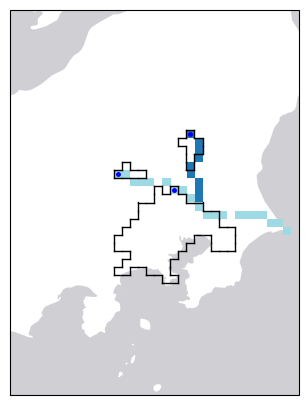

In [194]:
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

#
left = 138
right = 141
bottom = 34
top = 38
#
resolution=12
nx, ny = (right - left)*resolution, (top - bottom)*resolution
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
extent = (-180, 180, -90, 90)
#
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution
#

projection = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': projection})
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)
edges, riv_path_array, coords_a, rivnum_list_removed = updown(new_basin_to_cities, key_index=0)
tmp = np.ma.masked_where(riv_path_array == 0, riv_path_array)
im = ax.imshow(tmp, extent=extent, transform=ccrs.PlateCarree(), cmap='tab20')

for city_num in rivnum_list_removed:
    ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
    mask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
    draw_mask_sotowaku(extent, mask, ax=ax, sotowaku_color='black', linewidth=1)
    #prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
    #prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)

def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat
latlon_coords = [grid_to_latlon(row[0], col[0], extent) for row, col in coords_a]
for lon, lat in latlon_coords:
    ax.plot(lon, lat, marker='o', color='blue', markersize=2.5, transform=ccrs.PlateCarree())

ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

plt.show()